This is a tutorial on the 3D geometry used in `DiffDRR`.
It includes:

- An overview of the 3D visualization functions
- A description of the projective geometry underlying DRR rendering
- A brief explanation of the connection to C-arms

## 3D visualization with `PyVista`

Visualizing the 3D geometry of the X-ray detector in `DiffDRR` can be a helpful sanity check and is useful for debugging. We enable visualization of the `DiffDRR` setup using `PyVista`. The dependencies are `pyvista`, `trame`, and `vtk`.

The 3D visualization functions in `DiffDRR` perform the following steps:

- Extract a mesh from your CT volume
- Plot a pyramid frustum to visualize the camera pose
- Plot the detector plane with the DRR embedded as a texture
- Draw the principal ray from the X-ray source to the detector plane

We currently support the following backends for extracting meshes from CT scans:

- [MarchingCubes](https://docs.pyvista.org/version/stable/examples/01-filter/flying_edges.html#marching-cubes)
- [SurfaceNets](https://www.kitware.com/really-fast-isocontouring/)

As of `DiffDRR v0.4.0`, we also support the rendering of 3D labelmaps (e.g., segmentations of CT scans with [TotalSegmentator](https://github.com/wasserth/TotalSegmentator)).

In [ ]:
#| code-fold: true
import matplotlib.pyplot as plt
import pyvista
import torch

from diffdrr.data import load_example_ct
from diffdrr.drr import DRR
from diffdrr.pose import convert
from diffdrr.visualization import drr_to_mesh, img_to_mesh, labelmap_to_mesh, plot_drr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Read in the CT volume
subject = load_example_ct()

# Make a mesh from the CT volume
ct = drr_to_mesh(subject, "surface_nets", threshold=225, verbose=True)






leaning: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████[00:00<00:00]

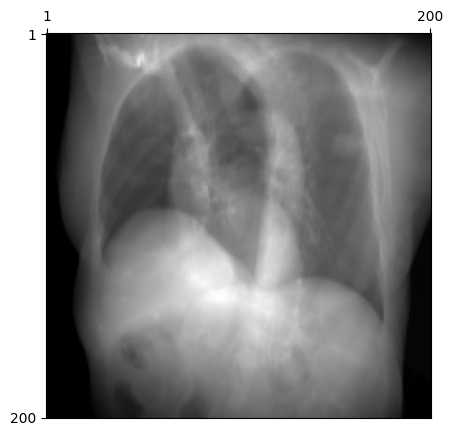

In [ ]:
# Initialize the DRR module for generating synthetic X-rays
drr = DRR(subject, sdd=1020.0, height=200, delx=2.0).to(device)

# Make a pose
rot = torch.tensor([[45.0, 30.0, 0.0]], device=device) / 180 * torch.pi
xyz = torch.tensor([[0.0, 800.0, 0.0]], device=device)
pose = convert(rot, xyz, parameterization="euler_angles", convention="ZXY")
plot_drr(drr(pose))
plt.show()

In [ ]:
# Make a mesh from the camera and detector plane
camera, detector, texture, principal_ray = img_to_mesh(drr, pose)

# Make the plot
plotter = pyvista.Plotter()
plotter.add_mesh(ct)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="lime", line_width=3)
plotter.add_mesh(detector, texture=texture)

# Render the plot
plotter.add_axes()
plotter.add_bounding_box()
plotter.show_bounds(grid="front", location="outer", all_edges=True)

# plotter.show()  # If running Jupyter locally
# plotter.show(jupyter_backend="server")  # If running Jupyter remotely
plotter.export_html("render.html")

2025-05-19 16:35:20.900 (  21.193s) [    7FAED28B5740]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=


In [ ]:
from IPython.display import IFrame

IFrame("render.html", height=500, width=749)

### Rendering labelmaps

The `SurfaceNets` algorithm was actually originally designed for the visualization of 3D labelmaps.
Running it on segmentation masks produced by `TotalSegmentator` produces detailed renderings.

In [ ]:
from matplotlib.colors import ListedColormap

mask = labelmap_to_mesh(drr.subject)
cmap = ListedColormap(
    [
        "#66c2a5",
        "#fc8d62",
        "#8da0cb",
        "#e78ac3",
        "#a6d854",
        "#ffd92f",
        "#e5c494",
        "#b3b3b3",
    ]
    * 15
)

plotter = pyvista.Plotter()
plotter.add_mesh(mask, cmap=cmap)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="lime", line_width=3)
plotter.add_mesh(detector, texture=texture)
plotter.add_axes()
plotter.add_bounding_box()
plotter.remove_scalar_bar()
plotter.export_html("mask.html")




leaning: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████[00:00<00:00]

In [ ]:
IFrame("mask.html", height=500, width=749)

## Projective geometry

X-ray imaging systems can be accurately modelled as pinhole cameras.
What follows is a brief description of the projective geometry underlying
pinhole cameras, as it applies to `DiffDRR`. A more comprehensive overview
can be found in Hartley and Zisserman (Chapter 5) or numerous online resources.

### Intrinsic parameters

In `DiffDRR`, the intrinsic parameters are

- `sdd` : the source to detector distance (i.e., the C-arm's focal length)
- `delx` : the x-direction pixel spacing (in mm)
- `dely` : the y-direction pixel spacing (in mm)
- `x0` : the principal point offset in the x-direction
- `y0` : the principal point offset in the y-direction

These direclty form the intrinsic matrix (with physical units) of a pinhole camera.
For most imaging systems, these parameters are directly found in the DICOM.


### Extrinsic parameters

The extrinsic parameters comprise an affine transform, written as $\mathbf T \in \mathbf{SE}(3)$, which is an element of a particular manifold of $4 \times 4$ matrices. There are many ways to parameterize affine transforms. For particulars on how this is implemented in `DiffDRR`, see the module [`diffdrr.pose`](https://vivekg.dev/DiffDRR/api/pose.html).

The simplest way of parameterizing an affine transform is with a translation and a rotation written in Euler angles. In fact, this is how camera poses are often stored in DICOM.

## Relation to C-arms

For an example, consider the pose rendered above:

In [ ]:
rot = torch.tensor([[45.0, 30.0, 0.0]], device=device) / 180 * torch.pi
xyz = torch.tensor([[0.0, 800.0, 0.0]], device=device)
pose = convert(rot, xyz, parameterization="euler_angles", convention="ZXY")

This corresponds to the following sequence of transforms:

- A translation of +800 along the y-axis
- A rotation by 45 degrees about the z-axis
- A rotation by 30 degress about the x-axis

which produces the oblique view visualized above.

#### What if the C-arm is behind the patient?

Many medical disciplies have C-arms where the source is positioned behind the patient (e.g., X-ray angiography). In these cases, the CT can be loaded with the `PA` orientation:

In [ ]:
subject = load_example_ct(orientation="PA")

This will produce the desired behavior. The only difference is that the `y` parameter in `rot` needs to be negated.

#### On representations of rotations

There are many ways to represent 3D rotations, and Euler angles are but one option.
In general, Euler angles are the most *human-understandable* parameterization. However,
they're not the best for optimization problems. For solving problems like [2D/3D registration](https://vivekg.dev/DiffDRR/tutorials/optimizers.html), higher-dimensional representations have emperically better performance.